In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import *
from model.classification import *
from train_classification import *

from tqdm.notebook import tqdm
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
files = [
    '20190819-Kutna Hora-L14-out-MVI_0005',
    '20190819-Kutna Hora-L10-out-SDV_1888',
    '20190819-Kutna Hora-L1-out-MVI_0007',
    '20190819-Ricany-L9-in-MVI_0008',
    '20190819-Ricany-L3-in-MVI_0006'
]

files = np.loadtxt('data/cross_validation/5_folds/tst/3.txt', dtype=str, delimiter='\n')
files = np.loadtxt('data/cross_validation/5_folds/trn/3.txt', dtype=str, delimiter='\n')[:5]

In [103]:
def extract_features(datapool, is_trn=None):
    model.eval()
    
    device = next(model.parameters()).device
    
    files = list(datapool.keys())
    outputs = []
    labels_all = []
    predictions_all = []
    for video in datapool:
        sr = config.sr
        audio = video.signal
        events = video.events
        
        if is_trn is None:
            samples, labels = create_dataset_sequentially(audio, sr, events, window_length=config.window_length)
        else:
            from_time, till_time = video.get_from_till_time(is_trn)
            samples, labels = create_dataset_sequentially(audio, sr, events, from_time, till_time, window_length=config.window_length)
        
        labels_all.append(labels)
        features_512 = []
        with torch.no_grad():
            for sample in tqdm(samples):
                features = transform(sample).unsqueeze(0)
                features = features.to(device)
                output = model(features)
                prediction = output.flatten().argmax().item()
                predictions_all.append(prediction)
                features_512.append(output.cpu().detach().squeeze().numpy())
            features_512 = np.array(features_512)
            outputs.append(features_512)
    return outputs, labels_all, predictions_all

In [104]:
def plot(outputs, labels):
    X = np.vstack(outputs)
    X_embedded = TSNE(n_components=2).fit_transform(X)
    
    # X_embedded = PCA(n_components=2).fit_transform(X)
    
    plt.figure(figsize=(20, 20))
    idx_from = 0
    colors = mcolors.TABLEAU_COLORS
    for o, (l, m, _), c in zip(outputs, labels, colors):
        X_embedded_k = X_embedded[idx_from: idx_from + len(o)]
        s = ((np.array(l) + 1) * 6) ** 2

        xs = X_embedded_k[:, 0]
        ys = X_embedded_k[:, 1]
        plt.scatter(xs, ys, marker=m, s=s, alpha=0)
        for x, y, text in zip(xs, ys, l):
            prefix = r'\hat' if m == '*' else ''
            text = f'${prefix}{text}$'
            plt.text(x, y, text, c=c, fontsize=16, fontweight='bold')
        
        idx_from += len(o)

In [5]:
fold = 0
# model, config = load_model_locally(f'cross_validation/{fold}')
model, config = load_model_locally(f'cross_validation_25/{fold}', model_name='rvce')
transform = create_transformation(config)
# model.model.fc = nn.Identity()

In [6]:
# files_tst = np.loadtxt(f'data/cross_validation/5_folds/tst/{fold}.txt', dtype=str, delimiter='\n')
files_tst = np.loadtxt(f'data/cross_validation/25_folds/tst/{fold}.txt', dtype=str, delimiter='\n')
files_tst = np.atleast_1d(files_tst)
datapool_tst = DataPool(files_tst, config.window_length, config.split_ratio, tqdm=tqdm)
outputs_tst, labels_tst, predictions_tst = extract_features(datapool_tst)

Video loading:   0%|          | 0/1 [00:00<?, ?it/s]

NameError: name 'extract_features' is not defined

In [116]:
# files_trn = np.loadtxt(f'data/cross_validation/5_folds/trn/{fold}.txt', dtype=str, delimiter='\n')[:5]
# files_trn = np.loadtxt(f'data/cross_validation/25_folds/trn/{fold}.txt', dtype=str, delimiter='\n')[:5]
files_trn = np.loadtxt(f'data/cross_validation/25_folds/trn/{fold}.txt', dtype=str, delimiter='\n')
files_trn = np.atleast_1d(files_trn)
datapool_trn = DataPool(files_trn, config.window_length, config.split_ratio, tqdm=tqdm)
outputs_trn, labels_trn, predictions_trn = extract_features(datapool_trn, is_trn=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 162.36it/s]


In [8]:
labels_all = []
outputs_all = []
colors = mcolors.TABLEAU_COLORS 

for l, o, c in zip(labels_trn, outputs_trn, colors):
    labels_all.append([l, 'o', c])
    outputs_all.append(o)

for l, o, c in zip(labels_tst, outputs_tst, colors):
    labels_all.append([l, '*', c])
    outputs_all.append(o)

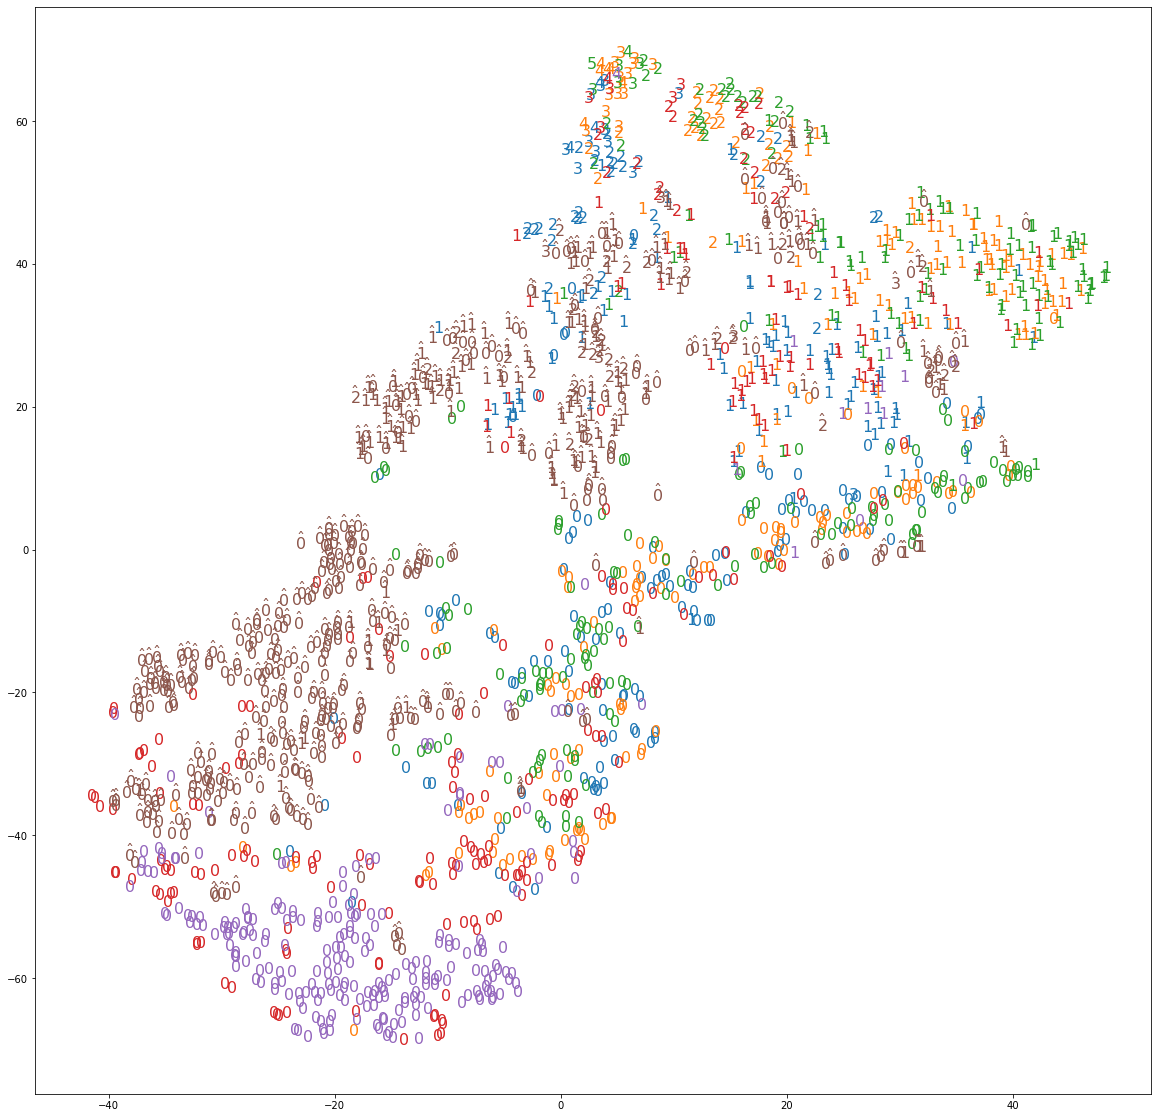

In [83]:
plot(outputs_all, labels_all)

In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [143]:
def get_confusion_matrix(labels, predictions):
    labels = np.array(labels).flatten()
    predictions = np.array(predictions).flatten()
    conf_matrix = confusion_matrix(labels, predictions)
    return conf_matrix

conf_matrix = get_confusion_matrix(labels_tst, predictions_tst)

conf_matrix_dist = (conf_matrix.T / conf_matrix.sum(1)).T
conf_matrix_dist[np.isnan(conf_matrix_dist)] = 0

In [144]:
# np.abs(np.array(labels_tst) - np.array(predictions_tst)).mean()

In [145]:
# labels_tst.sum()

In [147]:
np.abs(np.sum(predictions_tst) - np.sum(labels_tst)) / np.sum(labels_tst)

0.0603448275862069

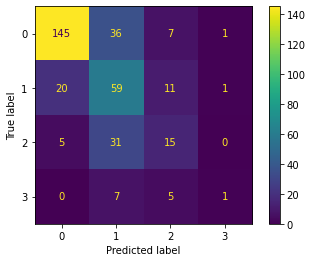

In [148]:
ConfusionMatrixDisplay(conf_matrix).plot();

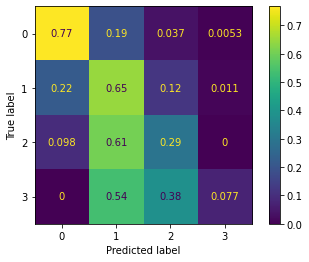

In [149]:
ConfusionMatrixDisplay(conf_matrix_dist).plot();